# Advanced Salary Retirement Model in Python

This is a retirement model which models salary with both a constant growth rate for cost of living raises as well as regular salary increases for promotions. The model is broken up into the following sections:
- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model
- [**Salaries**](#Salaries): Determining the salary in each year, considering cost of living raises and promotions
- [**Wealths**](#Wealths): Determining the wealth in each year, considering a constant savings rate and investment rate
- [**Retirement**](#Retirement): Determines years to retirement from the wealths over time, the main output from the model.

## Setup

Setup for the later calculations are here. The necessary packages are imported.

In [24]:
from dataclasses import dataclass
import numpy_financial as npf
import pandas as pd

## Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [3]:
@dataclass
class ModelInputs:
    starting_salary: int = 60000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.02
    promo_raise: float = 0.15
    savings_rate: float = 0.25
    interest_rate: float = 0.05
    annual_cash_spend: int = 40000
    years_in_retirement: int = 25
    desired_cash: int = 1500000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, annual_cash_spend=40000, years_in_retirement=25, desired_cash=1500000)

In [4]:
def dynamic_desired_cash(annual_cash_spend, years_in_retirement, interest_rate):
    # I used the present value of an annuity formula to calculate how much is needed to spend 
    # for n years in retirement
    desired_cash = npf.pv(rate=interest_rate, nper=years_in_retirement, pmt=-annual_cash_spend, fv=0)
    return abs(desired_cash)

## Salaries

Here the salary for each year is calculated. We assume that the salary grows at a constant rate each year for cost of living raises, and then also every number of years, the salary increases by a further percentage due to a promotion or switching jobs. Based on this assumption, the salary would evolve over time with the following equation:

$$s_t = s_0 (1 + r_{cl})^n (1 + r_p)^p$$

Where:
- $s_t$: Salary at year $t$
- $s_0$: Starting salary (year 0)
- $r_{cl}$: Annual cost of living raise
- $r_p$: Promotion raise
- $p$: Number of promotions

And in Python format:

In [5]:
def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t

That function will get the salary at a given year, so to get all the salaries we just run it on each year. But we will not know how many years to run as we should run it until the individual is able to retire. So we are just showing the first few salaries for now and will later use this function in the [Wealths](#Wealths) section of the model.

In [15]:
for i in range(8):
    year = i + 1
    salary = salary_at_year(model_data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $61,200.
The salary at year 2 is $62,424.
The salary at year 3 is $63,672.
The salary at year 4 is $64,946.
The salary at year 5 is $76,182.
The salary at year 6 is $77,705.
The salary at year 7 is $79,259.
The salary at year 8 is $80,844.


As expected, with the default inputs, the salary is increasing at 2% per year. Then at year 5, there is a promotion so there is a larger increase in salary.

## Wealths

The wealths portion of the model is concerned with applying the savings rate to the earned salary to calculate the cash saved, accumulating the cash saved over time, and applying the investment rate to the accumulated wealth.

To calculate cash saved, it is simply:

$$c_t = s_t * r_s$$

Where:
- $c_t$: Cash saved during year $t$
- $r_s$: Savings rate

In [7]:
def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

To get the wealth at each year, it is just applying the investment return to last year's wealth, then adding this year's cash saved:

$$w_t = w_{t-1} (1 + r_i) + c_t$$
Where:
- $w_t$: Wealth at year $t$
- $r_i$: Investment rate

In [8]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

Again, just like in the [Salaries](#Salaries) section, we can now get the output for each year, but we don't know ultimately how many years we will have to run it. That will be determined in the [Retirement](#Retirement) section. So for now, just show the first few years of wealth accumulation:

In [16]:
prior_wealth = 0  # starting with no cash saved
for i in range(8):
    year = i + 1
    wealth = wealth_at_year(model_data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.


With default inputs, the wealth is going up by approximately 25% of the salary each year, plus a bit more for investment. Then in year 6 we see a substantially larger increase because the salary is substantially larger due to the promotion. So everything is looking correct.

## Retirement

This section of the model puts everything together to produce the final output of years to retirement. It uses the logic to get the wealths at each year, which in turn uses the logic to the get salary at each year. The wealth at each year is tracked over time until it hits the desired cash. Once the wealth hits the desired cash, the individual is able to retire so that year is returned as the years to retirement.

In [17]:
def years_to_retirement(data: ModelInputs, print_output = True):
    
    # Calculate annual savings from the salary and savings rate
    annual_savings = model_data.starting_salary * model_data.savings_rate
    
    # Calculate the dynamic desired_cash using the new inputs
    data.desired_cash = dynamic_desired_cash(
        model_data.annual_cash_spend,
        model_data.years_in_retirement,
        model_data.interest_rate
    )
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    year = 0  # will become 1 on first loop
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

In [18]:
years = years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.
The wealth at year 9 is $195,939.
The wealth at year 10 is $229,918.
The wealth at year 11 is $266,080.
The wealth at year 12 is $304,542.
The wealth at year 13 is $345,431.
The wealth at year 14 is $388,878.
The wealth at year 15 is $439,025.
The wealth at year 16 is $492,294.
The wealth at year 17 is $548,853.
The wealth at year 18 is $608,878.

Retirement:
It will take 18 years to retire.


- We want to put these returns into a dataframe, let's do this using a function that runs the entire model that we have created so far and puts these results in a DataFrame.

In [25]:
def salaries_wealth_df(data):
    prior_wealth = 0  
    wealth = 0
    year = 0 
    
    df_salwealth_data = []
    while wealth < data.desired_cash:
        year = year + 1
        salary = salary_at_year(data, year)
        wealth = wealth_at_year(data, year, prior_wealth)

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
        # Save the results in a tuple for later building the DataFrame
        df_salwealth_data.append((year, salary, wealth))
        
    # Now we have exited the while loop, so wealth must be >= desired_cash
    
    # Now create the DataFrame
    df = pd.DataFrame(df_salwealth_data, columns=['Year', 'Salary', 'Wealth'])
    
    return df

- we also want to format the DataFrame display for the decimal numbers after the figures and to include the `$` in front of each value

- we are setting to 2 decimal points for both wealth and salary

In [26]:
def format_sal_wealths(df):
    return df.style.format({
        'Salary': '${:,.2f}',
        'Wealth': '${:,.2f}'
    })

In [27]:
# then we can call the functions and save the results in a dataframe
df = salaries_wealth_df(model_data)
format_sal_wealths(df)

## Sensitivity Analysis

- Here, we want to determine how much the years to retirement changes in response to the different inputs.

In [28]:
import sensitivity
import pandas as pd
from sensitivity import SensitivityAnalyzer
import random

In [33]:
def years_to_retirementSeA(data: ModelInputs, print_output = False):
    
    # Calculate annual savings from the salary and savings rate
    annual_savings = model_data.starting_salary * model_data.savings_rate
    
    # Calculate the dynamic desired_cash using the new inputs
    data.desired_cash = dynamic_desired_cash(
        model_data.annual_cash_spend,
        model_data.years_in_retirement,
        model_data.interest_rate
    )
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    year = 0  # will become 1 on first loop
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

With the default inputs:

In [34]:
years = years_to_retirementSeA(model_data)

Wealths over time:
The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.
The wealth at year 9 is $195,939.
The wealth at year 10 is $229,918.
The wealth at year 11 is $266,080.
The wealth at year 12 is $304,542.
The wealth at year 13 is $345,431.
The wealth at year 14 is $388,878.
The wealth at year 15 is $439,025.
The wealth at year 16 is $492,294.
The wealth at year 17 is $548,853.
The wealth at year 18 is $608,878.

Retirement:
It will take 18 years to retire.


In [32]:
# create a function that takes the separate arguments, create a dataclass from those arguments 
# pass the dataclass into the function and returns the results 
# arbitrary
def y2r_separate_args(**kwargs):
    print(kwargs)
    dataSeA = ModelInputs(**kwargs)
    return years_to_retirementSeA(dataSeA)

y2r_separate_args()

{}


18

In [14]:
[i for i in range(4,8)]

[4, 5, 6, 7]

In [15]:
sensitivity_val = {
    'starting_salary':[i * 10000 for i in range(4,8)],
    'promos_every_n_years':[i for i in range(4,8)],
    'cost_of_living_raise':[i / 100 for i in range(1,4)],
    'promo_raise': [i/100 for i in range(10,25,5)],
    'interest_rate': [i/100 for i in range(3,7)],
    'savings_rate':[i/100 for i in range(10,40,10)],
    'desired_cash': [i * 1000000 for i in range(10,26,5)],
}

labels = {
    'starting_salary' : "Starting Salary",
    'promos_every_n_years' : 'Step-Year Promotion',
    'cost_of_living_raise': 'Cost of Living Raise',
    'promo_raise': 'Promo Raise',
    'interest_rate': "Interest Rate",
    'savings_rate': 'Savings Rate',
    'desired_cash': 'Desired Cash',
    
}

sa = SensitivityAnalyzer (
    sensitivity_val,
    y2r_separate_args,
    result_name= "Years to Retirement",
    reverse_colors = True,
    grid_size=3,
    labels = labels,
    num_fmt='{:.0f}'
    )

  3%|█▏                                    | 214/6912 [00:00<00:03, 2131.85it/s]

{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'sa

  7%|██▌                                   | 465/6912 [00:00<00:02, 2352.31it/s]

{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'sa

 14%|█████▎                                | 963/6912 [00:00<00:02, 2447.52it/s]

{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.0

 18%|██████▌                              | 1218/6912 [00:00<00:02, 2484.28it/s]

{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'sa

 21%|███████▉                             | 1477/6912 [00:00<00:02, 2519.32it/s]

{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.0

 29%|██████████▊                          | 2016/6912 [00:00<00:01, 2613.70it/s]

{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'sa

 33%|████████████▏                        | 2278/6912 [00:00<00:01, 2554.74it/s]

{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'sa

 37%|█████████████▌                       | 2534/6912 [00:01<00:01, 2534.01it/s]

{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.0

 40%|██████████████▉                      | 2788/6912 [00:01<00:01, 2501.77it/s]

{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.0

{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'sa

 47%|█████████████████▌                   | 3276/6912 [00:01<00:01, 2265.16it/s]

{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'sa

{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'sa

 55%|████████████████████▏                | 3774/6912 [00:01<00:01, 2371.93it/s]

{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'sa

 58%|█████████████████████▌               | 4034/6912 [00:01<00:01, 2437.88it/s]

{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'sa

 66%|████████████████████████▏            | 4530/6912 [00:01<00:00, 2458.97it/s]

{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.1, 'interest_rate': 0.03, 'sa

{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.0

 73%|██████████████████████████▉          | 5024/6912 [00:02<00:00, 2449.00it/s]

{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.04, 'sa

{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'sa

 76%|████████████████████████████▏        | 5270/6912 [00:02<00:00, 2319.65it/s]

{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'sa

 80%|█████████████████████████████▌       | 5528/6912 [00:02<00:00, 2391.83it/s]

{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'sa

 84%|██████████████████████████████▉      | 5781/6912 [00:02<00:00, 2431.41it/s]

{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.0

 87%|████████████████████████████████▎    | 6042/6912 [00:02<00:00, 2482.70it/s]

{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.06, 'sa

 95%|███████████████████████████████████  | 6560/6912 [00:02<00:00, 2538.48it/s]

{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.04, 'sa

{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.03, 'sa

100%|█████████████████████████████████████| 6912/6912 [00:02<00:00, 2455.25it/s]

{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.0

In [16]:
sa.df

Starting Salary  Step-Year Promotion  Cost of Living Raise  Promo Raise  \
0               40000                    4                  0.01          0.1   
1               40000                    4                  0.01          0.1   
2               40000                    4                  0.01          0.1   
3               40000                    4                  0.01          0.1   
4               40000                    4                  0.01          0.1   
...               ...                  ...                   ...          ...   
6907            70000                    7                  0.03          0.2   
6908            70000                    7                  0.03          0.2   
6909            70000                    7                  0.03          0.2   
6910            70000                    7                  0.03          0.2   
6911            70000                    7                  0.03          0.2   

      Interest Rate  Savings Rate  Desired Cash  Years to Retirement  
0              0.03           0.1      10000000                   41  
1              0.03           0.1      15000000                   41  
2              0.03           0.1      20000000                   41  
3              0.03           0.1      25000000                   41  
4              0.03           0.2      10000000                   30  
...             ...           ...           ...                  ...  
6907           0.06           0.2      25000000                   17  
6908           0.06           0.3      10000000                   14  
6909           0.06           0.3      15000000                   14  
6910           0.06           0.3      20000000                   14  
6911           0.06           0.3      25000000                   14  

[6912 rows x 8 columns]

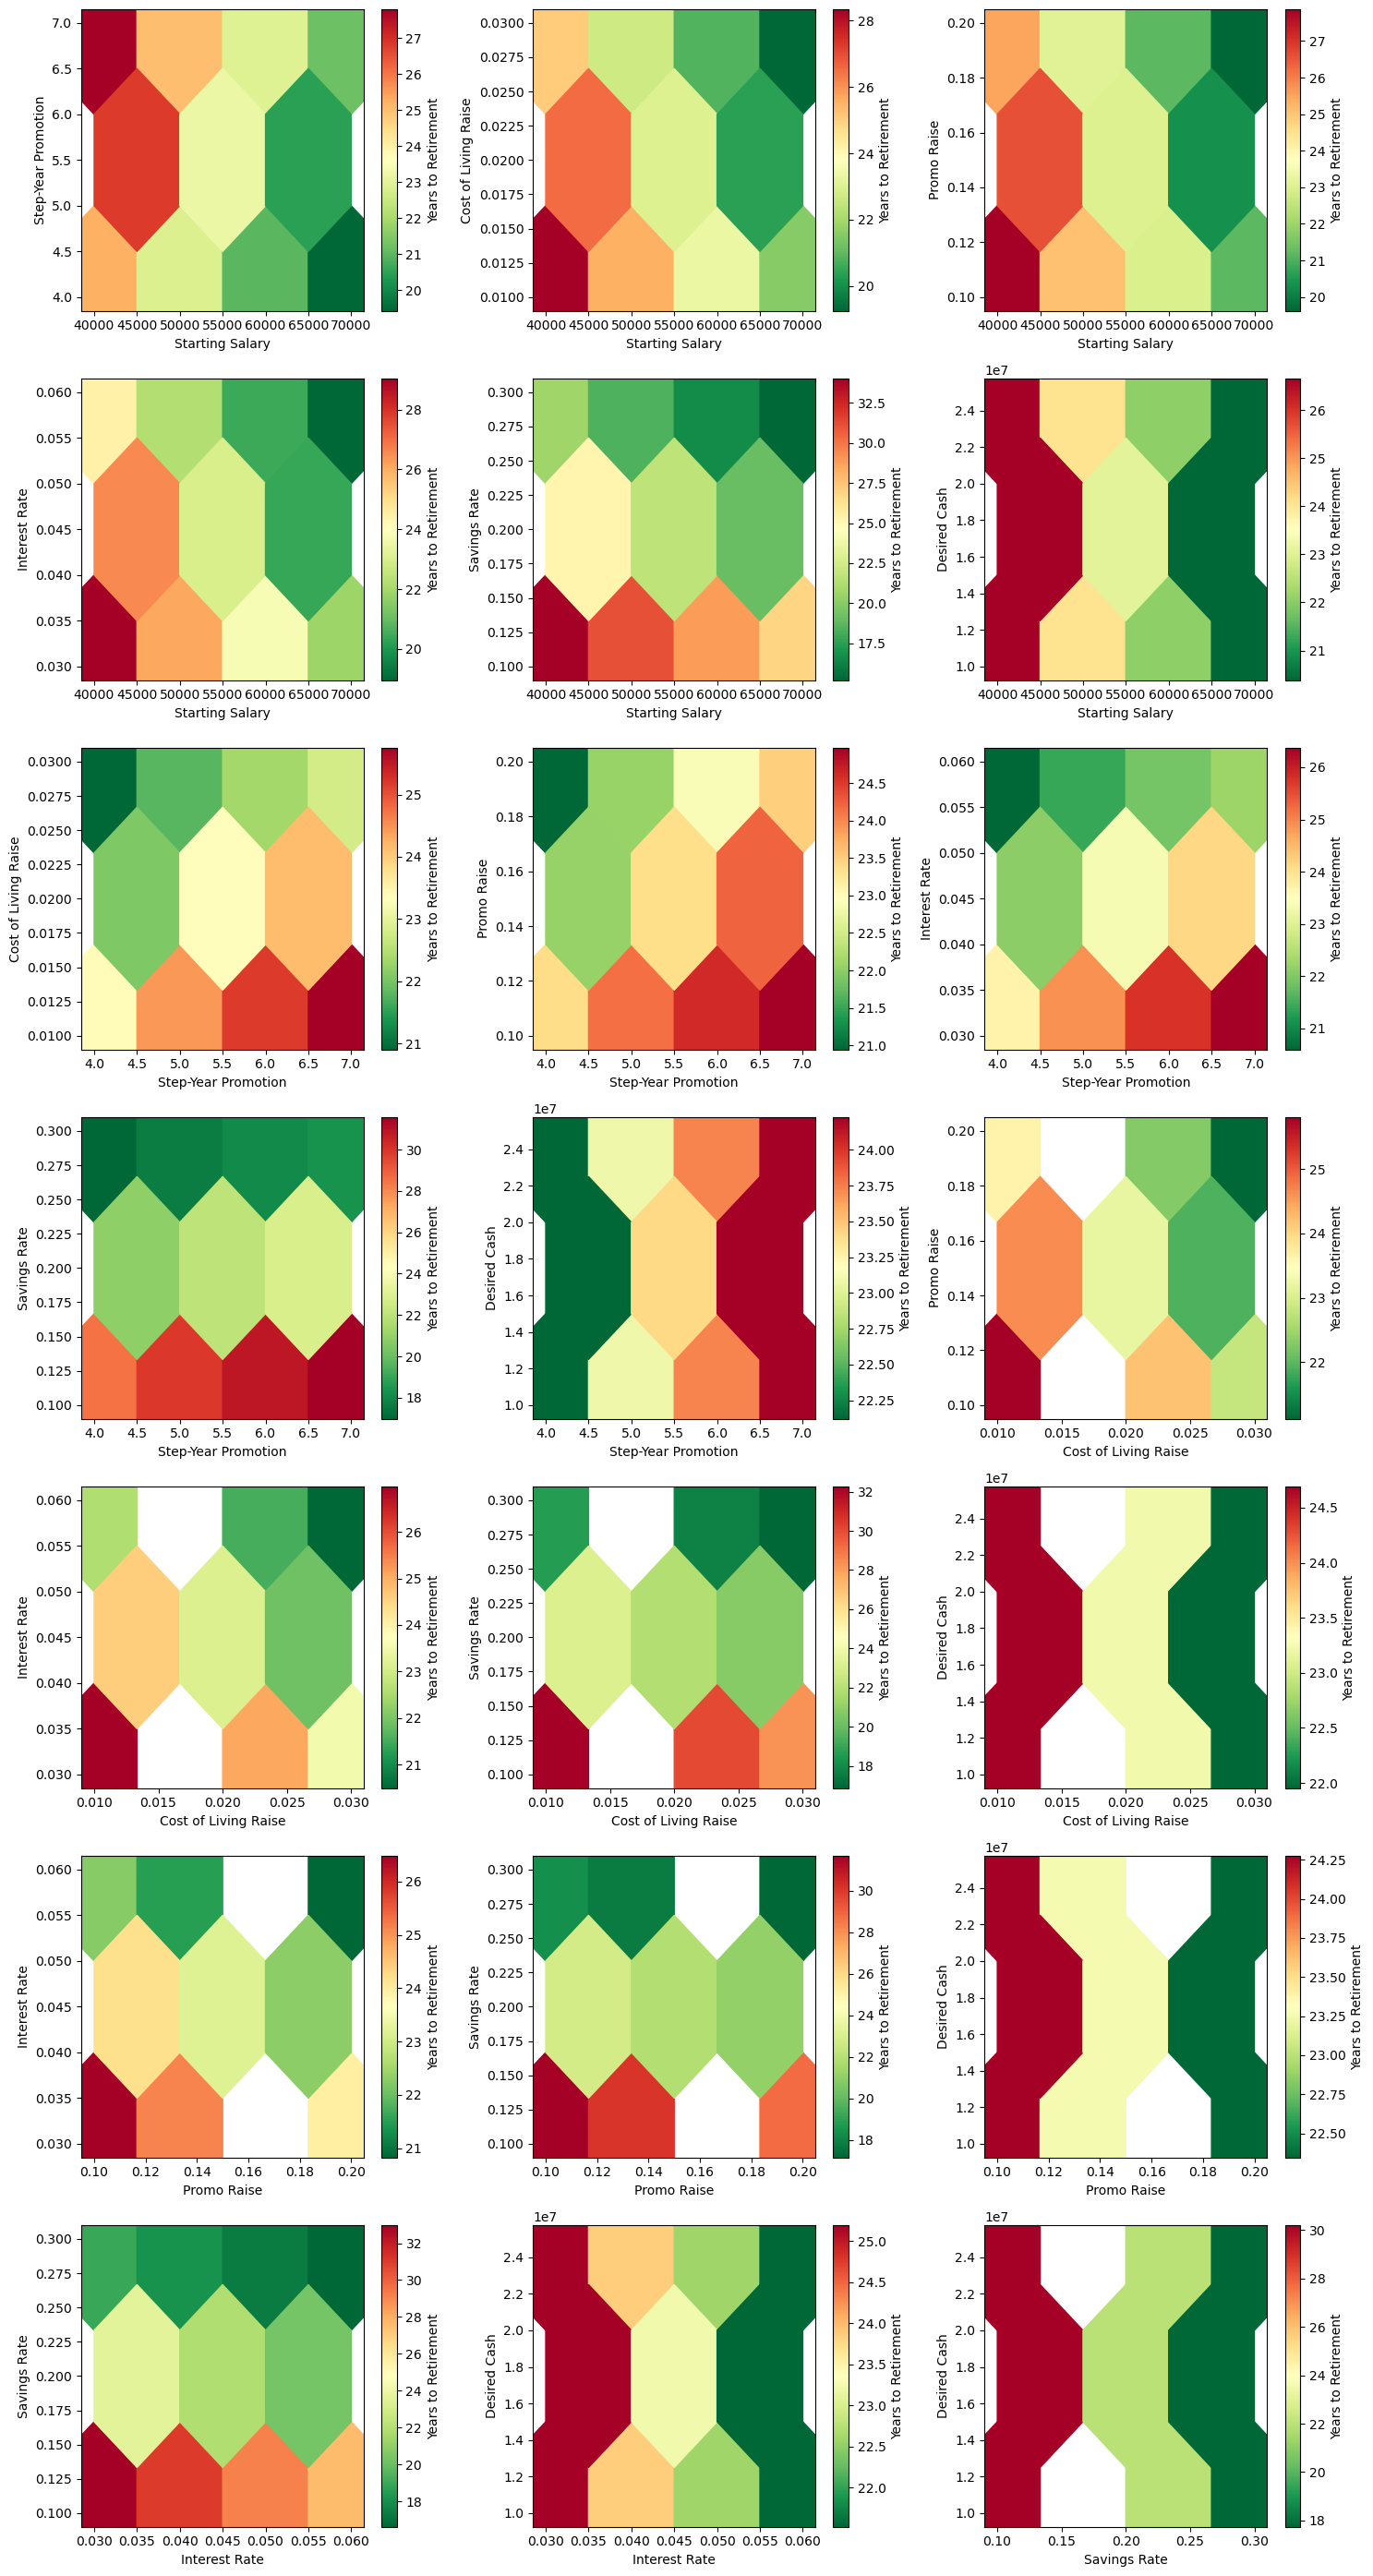

In [17]:
plot = sa.plot()

In [18]:
styled_df = sa.styled_dfs()

## Scenario Analysis

In [19]:
# set up the different input cases for the scenarios using a dictionary

bad_economy_data = ModelInputs(
    
    starting_salary = 40000,
    promos_every_n_years = 8,
    cost_of_living_raise = 0.01,
    promo_raise = 0.07,
    savings_rate = 0.15,
    interest_rate = 0.03
)

good_economy_data = ModelInputs(
    
    starting_salary = 70000,
    promos_every_n_years = 4,
    cost_of_living_raise = 0.03,
    promo_raise = 0.2,
    savings_rate = 0.35,
    interest_rate = 0.06
)

cases = {
    'Recession': bad_economy_data,
    'Normal': model_data,
    'Expansion': good_economy_data
}

In [20]:
# years to retirement for this model

for case_type, case_inputs in cases.items():
#     print(case_type,case_inputs)
    ytr = years_to_retirementSeA(case_inputs, print_output = False)
    print(f'It would take {ytr} years to retire in a {case_type} economy.')

It would take 39 years to retire in a Recession economy.
It would take 18 years to retire in a Normal economy.
It would take 12 years to retire in a Expansion economy.


In [21]:
# take an expected value across the different scenarios and results with probabilities

case_probabilities = {
    'Recession': 0.2,
    'Normal': 0.5,
    'Expansion': 0.3
}

# calculate the expected value based on the probabilities - each probability * output - using a running total loop

expected_ytr = 0
for case_type, case_inputs in cases.items():
#     print(case_type,case_inputs)
    ytr = years_to_retirementSeA(case_inputs, print_output = False)
    weighted_ytr = ytr * case_probabilities[case_type]
    expected_ytr = expected_ytr + weighted_ytr
print(f'It would take {expected_ytr} years to retire in a {case_type} economy given a {case_probabilities["Recession"]:.0%} of recession and a {case_probabilities["Expansion"]:.0%} of an expansionary economy.')

It would take 20.4 years to retire in a Expansion economy given a 20% of recession and a 30% of an expansionary economy.


## Internal Randomness

In [22]:
@dataclass
class InRInputs:
    starting_salary: tuple = (40000,60000,70000)
    promos_every_n_years: tuple = (8,5,4)
    cost_of_living_raise: tuple = (0.01, 0.02, 0.03)
    promo_raise: tuple = (0.07,0.15,0.2)
    savings_rate: tuple = (0.15,0.25,0.35)
    interest_rate: tuple = (0.03,0.05,0.06)
    desired_cash: int = 1500000
    recession_prob: float = 0.2
    expansion_prob: float = 0.3
    case_names: tuple = ('Recession', 'Normal', 'Expansion')
    n_iter: int = 1000
        
InR_data = InRInputs()
InR_data

InRInputs(starting_salary=(40000, 60000, 70000), promos_every_n_years=(8, 5, 4), cost_of_living_raise=(0.01, 0.02, 0.03), promo_raise=(0.07, 0.15, 0.2), savings_rate=(0.15, 0.25, 0.35), interest_rate=(0.03, 0.05, 0.06), desired_cash=1500000, recession_prob=0.2, expansion_prob=0.3, case_names=('Recession', 'Normal', 'Expansion'), n_iter=1000)

In [23]:
# we want to create a function where we can automatically tell whether we are in recession, normal or expansion period
def economy_status(data):
    normal_probability = 1 - InR_data.recession_prob - InR_data.expansion_prob
    economy_state = random.choices([0,1,2], weights = [InR_data.recession_prob, normal_probability, InR_data.expansion_prob])[0]
    return economy_state

In [24]:
case = economy_status(InR_data)

In [25]:
# new functions based on economic conditions based on scenario analysis

def salary_at_yearInR(data: InRInputs, year, case):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years [case])
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary [case] * (1 + data.cost_of_living_raise [case]) ** year * (1 + data.promo_raise[case]) ** num_promos
    return salary_t

def cash_saved_during_yearInR(data: InRInputs, year, case):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_yearInR(data, year, case)
    cash_saved = salary * data.savings_rate [case]
    return cash_saved

def wealth_at_yearInR(data: InRInputs, year, prior_wealth, case):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_yearInR(data, year, case)
    wealth = prior_wealth * (1 + data.interest_rate[case]) + cash_saved
    return wealth

def years_to_retirementInR (data: InRInputs, print_output = False):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    year = 0  # will become 1 on first loop
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        case = economy_status(data) #we want to get the case for every year
        case_type = data.case_names[case]
        wealth = wealth_at_yearInR(data, year, prior_wealth, case)
        if print_output:
            print(f'The wealth at year {year} ({case_type} economy)is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

In [26]:
# run the model based on the new adjustments
years_to_retirementInR(InR_data)

24

In [27]:
# because we are getting several outputs from our model due to internal randomness everytime we run the model
# we want to build a for loop that will enable us to run the models a certain number of times and summarize the results

all_ytrs = []
for i in range(InR_data.n_iter):
    ytr = years_to_retirementInR (InR_data, print_output = False)
    all_ytrs.append (ytr)
    
df_ytr = pd.DataFrame()
df_ytr['Years to Retirement'] = all_ytrs

In [28]:
avg_ytr = df_ytr['Years to Retirement'].mean()
std_ytr = df_ytr['Years to Retirement'].std()
max_ytr = df_ytr['Years to Retirement'].max()
min_ytr = df_ytr['Years to Retirement'].min()

print(
    f'It will take an average of {avg_ytr:.0f} years to retire with a standard deviation of {std_ytr:.0f} years' 
    f', a max of {max_ytr:.0f} years , and a minimum of {min_ytr:.0f} years')

It will take an average of 26 years to retire with a standard deviation of 2 years, a max of 33 years , and a minimum of 22 years


In [29]:
# bringing the 2 new logics together as a summarized function
def ytr_all_cases(data):
    all_ytrs = []
    for i in range(data.n_iter):
        ytr = years_to_retirementInR(data, print_output = False)
        all_ytrs.append (ytr)

    df_ytr = pd.DataFrame()
    df_ytr['Years to Retirement'] = all_ytrs
    return df_ytr

def summarise_ytr(df_ytr):

    avg_ytr = df_ytr['Years to Retirement'].mean()
    std_ytr = df_ytr['Years to Retirement'].std()
    max_ytr = df_ytr['Years to Retirement'].max()
    min_ytr = df_ytr['Years to Retirement'].min()

    print(
        f'It will take an average of {avg_ytr:.0f} years to retire with a standard deviation of {std_ytr:.0f} years' 
        f', a max of {max_ytr:.0f} years , and a minimum of {min_ytr:.0f} years')

# bringing both functions into a summary function for internal randomness

def summarize_ytr_all_cases(data):
    df_ytr = ytr_all_cases(data)
    summarise_ytr(df_ytr)

In [30]:
# now passing the summary function using a flexible desired cash
summarize_ytr_all_cases (InRInputs (desired_cash =  2000000))

It will take an average of 29 years to retire with a standard deviation of 2 years, a max of 34 years , and a minimum of 24 years


## Monte Carlo Simulation

In [31]:
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, annual_cash_spend=40000, years_in_retirement=25, desired_cash=563757.7826417905)

In [32]:
@dataclass
class SimulationInputs:
    n_iter: int = 10000
    starting_salary_std: float = 10000
    promos_every_n_years_std: float = 1.5
    promo_raise_std: float = 0.05
    cost_of_living_raise_std: float = 0.005
    savings_rate_std: float = 0.07
    interest_rate_std: float = 0.01
        
sim_data = SimulationInputs()
sim_data

SimulationInputs(n_iter=10000, starting_salary_std=10000, promos_every_n_years_std=1.5, promo_raise_std=0.05, cost_of_living_raise_std=0.005, savings_rate_std=0.07, interest_rate_std=0.01)

In [33]:
data = model_data

In [34]:
# fix the model such that our values results is positive and doesn't churn out a negative.
# we will use a while loop for you

import random
def random_positive_generator (mean, std):
    drawn_value = -1 # initialise & create the drawn_value variable
    while drawn_value < 0:
        drawn_value = random.normalvariate(mean, std)
    return drawn_value

In [35]:
random_positive_generator (15,109) #testing the function with random inputs to see if we get any negative values

31.79319493550137

In [36]:
# next , create the random value of all our inputs and randomly draw them 
def ytr_monte_carlo_sim (data, sim_data):
    starting_salary = random_positive_generator(data.starting_salary, sim_data.starting_salary_std) 
    promos_every_n_years = random_positive_generator(data.promos_every_n_years, sim_data.promos_every_n_years_std)
    cost_of_living_raise = random_positive_generator(data.cost_of_living_raise, sim_data.cost_of_living_raise_std)
    promo_raise= random_positive_generator(data.promo_raise, sim_data.promo_raise_std)
    savings_rate = random_positive_generator(data.savings_rate, sim_data.savings_rate_std) 
    interest_rate = random_positive_generator(data.interest_rate, sim_data.interest_rate_std) 
    
    return (starting_salary,
            promos_every_n_years,
            cost_of_living_raise,
            promo_raise,
            savings_rate,
            interest_rate)

In [37]:
# running a single simulation using the random data
# first, we assign the random functions generated from the function to a variable
def ytr_single_sim(data, sim_data):
    (           
        starting_salary,
        promos_every_n_years,
        cost_of_living_raise,
        promo_raise,
        savings_rate,
        interest_rate) = ytr_monte_carlo_sim (data, sim_data) 

    new_data = ModelInputs(
        starting_salary = starting_salary,
        promos_every_n_years = promos_every_n_years,
        cost_of_living_raise = cost_of_living_raise,
        promo_raise = promo_raise,
        savings_rate = savings_rate,
        interest_rate = interest_rate
)

    ytr_mcs = years_to_retirement(new_data, print_output = True)
    return(
        starting_salary, 
        promos_every_n_years,
        cost_of_living_raise,
        promo_raise,
        savings_rate,
        interest_rate,
        ytr_mcs
)

In [38]:
def final_ytr_mcs (data, sim_data):
    all_resultmcs = [ytr_single_sim (data, sim_data) for i in range (sim_data.n_iter)]
    dfmcs = pd.DataFrame(all_resultmcs, 
        columns = ['starting_salary', 
        'promos_every_n_years',
        'cost_of_living_raise',
        'promo_raise',
        'savings_rate',
        'interest_rate',
        'Years To Retirement'])
    return dfmcs

In [39]:
dfmcs = final_ytr_mcs(data, sim_data)

Wealths over time:
The wealth at year 1 is $9,507.
The wealth at year 2 is $19,622.
The wealth at year 3 is $30,373.
The wealth at year 4 is $41,793.
The wealth at year 5 is $53,912.
The wealth at year 6 is $66,766.
The wealth at year 7 is $80,388.
The wealth at year 8 is $96,126.
The wealth at year 9 is $112,791.
The wealth at year 10 is $130,428.
The wealth at year 11 is $149,083.
The wealth at year 12 is $168,803.
The wealth at year 13 is $189,639.
The wealth at year 14 is $211,642.
The wealth at year 15 is $236,602.
The wealth at year 16 is $262,951.
The wealth at year 17 is $290,755.
The wealth at year 18 is $320,081.
The wealth at year 19 is $350,999.
The wealth at year 20 is $383,583.
The wealth at year 21 is $417,908.
The wealth at year 22 is $454,055.
The wealth at year 23 is $494,459.
The wealth at year 24 is $537,005.
The wealth at year 25 is $581,791.

Retirement:
It will take 25 years to retire.
Wealths over time:
The wealth at year 1 is $14,626.
The wealth at year 2 is $3


Retirement:
It will take 18 years to retire.
Wealths over time:
The wealth at year 1 is $16,336.
The wealth at year 2 is $34,041.
The wealth at year 3 is $53,203.
The wealth at year 4 is $73,917.
The wealth at year 5 is $99,197.
The wealth at year 6 is $126,480.
The wealth at year 7 is $155,894.
The wealth at year 8 is $187,576.
The wealth at year 9 is $221,669.
The wealth at year 10 is $262,201.
The wealth at year 11 is $305,783.
The wealth at year 12 is $352,609.
The wealth at year 13 is $402,882.
The wealth at year 14 is $461,831.
The wealth at year 15 is $525,092.
The wealth at year 16 is $592,934.

Retirement:
It will take 16 years to retire.
Wealths over time:
The wealth at year 1 is $11,134.
The wealth at year 2 is $22,994.
The wealth at year 3 is $35,616.
The wealth at year 4 is $49,039.
The wealth at year 5 is $63,303.
The wealth at year 6 is $78,449.
The wealth at year 7 is $94,522.
The wealth at year 8 is $112,546.
The wealth at year 9 is $131,654.
The wealth at year 10 is 

The wealth at year 10 is $205,058.
The wealth at year 11 is $237,677.
The wealth at year 12 is $272,979.
The wealth at year 13 is $311,157.
The wealth at year 14 is $352,419.
The wealth at year 15 is $399,176.
The wealth at year 16 is $449,678.
The wealth at year 17 is $504,193.
The wealth at year 18 is $563,006.
The wealth at year 19 is $626,425.

Retirement:
It will take 19 years to retire.
Wealths over time:
The wealth at year 1 is $18,187.
The wealth at year 2 is $37,966.
The wealth at year 3 is $59,452.
The wealth at year 4 is $82,766.
The wealth at year 5 is $108,037.
The wealth at year 6 is $135,406.
The wealth at year 7 is $165,019.
The wealth at year 8 is $199,081.
The wealth at year 9 is $235,895.
The wealth at year 10 is $275,654.
The wealth at year 11 is $318,563.
The wealth at year 12 is $364,844.
The wealth at year 13 is $414,731.
The wealth at year 14 is $468,475.
The wealth at year 15 is $528,941.
The wealth at year 16 is $594,046.

Retirement:
It will take 16 years to 

Wealths over time:
The wealth at year 1 is $12,538.
The wealth at year 2 is $25,732.
The wealth at year 3 is $39,610.
The wealth at year 4 is $54,198.
The wealth at year 5 is $71,478.
The wealth at year 6 is $89,630.
The wealth at year 7 is $108,688.
The wealth at year 8 is $128,688.
The wealth at year 9 is $149,669.
The wealth at year 10 is $174,112.
The wealth at year 11 is $199,742.
The wealth at year 12 is $226,607.
The wealth at year 13 is $254,756.
The wealth at year 14 is $284,239.
The wealth at year 15 is $318,164.
The wealth at year 16 is $353,690.
The wealth at year 17 is $390,881.
The wealth at year 18 is $429,801.
The wealth at year 19 is $470,518.
The wealth at year 20 is $516,924.
The wealth at year 21 is $565,471.

Retirement:
It will take 21 years to retire.
Wealths over time:
The wealth at year 1 is $9,109.
The wealth at year 2 is $18,758.
The wealth at year 3 is $28,972.
The wealth at year 4 is $39,777.
The wealth at year 5 is $51,202.
The wealth at year 6 is $64,921.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
def styled_dfmcs(dfmcs):
    return dfmcs.style.format({
        'starting_salary': '${:,.0f}', 
        'promos_every_n_years': '{:.2f}',
        'cost_of_living_raise': '{:.2%}',
        'promo_raise': '{:.2%}',
        'savings_rate': '{:.2%}',
        'interest_rate':'{:.2%}',
        'Years To Retirement': '{:.0f}'
    }).background_gradient(cmap = 'RdYlGn_r', subset = ['Years To Retirement'])

# the additional _r in front of the RdYlGn_r is to reverse our output to show the green first before the red

# Visualization of the Results 

In [41]:
styled_dfmcs(dfmcs.head())

# YTR Distribution

<AxesSubplot:ylabel='Frequency'>

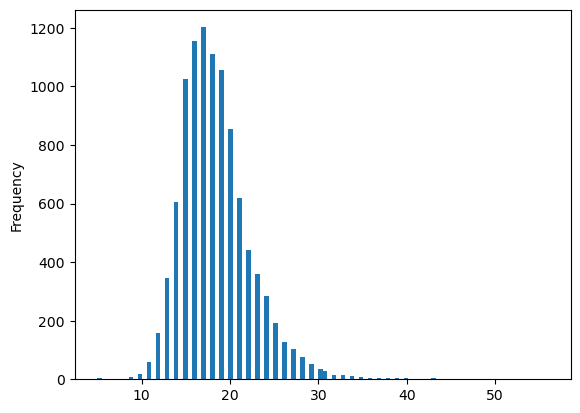

In [42]:
dfmcs['Years To Retirement'].plot.hist(bins=100)

# probability tables

In [43]:
styled_dfmcs(dfmcs.quantile([i/20 for i in range (1,20)]))

## Multivariate Regression

In [44]:
import statsmodels.api as sm


output_cols = 'Years To Retirement'

input_cols = [
        'starting_salary', 
        'promos_every_n_years',
        'cost_of_living_raise',
        'promo_raise',
        'savings_rate',
        'interest_rate',
]

X = dfmcs [input_cols] #these are our input variables used in determing the ytr
y = dfmcs [output_cols] # this is the ytr column

In [45]:
# create the regression model

mod = sm.OLS(y, X)
result_mcs = mod.fit()
result_mcs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Years To Retirement   R-squared (uncentered):                   0.947
Model:                             OLS   Adj. R-squared (uncentered):              0.947
Method:                  Least Squares   F-statistic:                          2.986e+04
Date:                 Sat, 28 Sep 2024   Prob (F-statistic):                        0.00
Time:                         21:20:08   Log-Likelihood:                         -28845.
No. Observations:                10000   AIC:                                  5.770e+04
Df Residuals:                     9994   BIC:                                  5.775e+04
Df Model:                            6                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
starting_salary       6.573e-05   3.53e-06     18.596      0.000    5.88e-05    7.27e-05
promos_every_n_years     1.5091      0.028     54.793      0.000       1.455       1.563
cost_of_living_raise   224.9687      7.933     28.359      0.000     209.419     240.519
promo_raise             11.5026      0.824     13.958      0.000       9.887      13.118
savings_rate           -22.3396      0.589    -37.943      0.000     -23.494     -21.185
interest_rate          117.6046      3.829     30.711      0.000     110.098     125.111
==============================================================================
Omnibus:                      884.499   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1685.909
Skew:                           0.605   Prob(JB):                         0.00
Kurtosis:                       4.607   Cond. No.                     1.12e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.12e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# no constant or intercept in our results, we need to manually add it by updating the X variable and
# overwriting our previous values:

X_updated = sm.add_constant(X)

mod = sm.OLS(y, X_updated)
result_mcs = mod.fit()
result_mcs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Years To Retirement   R-squared:                       0.876
Model:                             OLS   Adj. R-squared:                  0.876
Method:                  Least Squares   F-statistic:                 1.175e+04
Date:                 Sat, 28 Sep 2024   Prob (F-statistic):               0.00
Time:                         21:20:08   Log-Likelihood:                -17442.
No. Observations:                10000   AIC:                         3.490e+04
Df Residuals:                     9993   BIC:                         3.495e+04
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   43.4176      0.147    296.249      0.000      43.130      43.705
starting_salary         -0.0002   1.37e-06   -119.308      0.000      -0.000      -0.000
promos_every_n_years     0.6604      0.009     71.313      0.000       0.642       0.679
cost_of_living_raise   -88.9594      2.749    -32.362      0.000     -94.348     -83.571
promo_raise            -13.2246      0.276    -47.845      0.000     -13.766     -12.683
savings_rate           -42.9064      0.201   -213.840      0.000     -43.300     -42.513
interest_rate          -79.4291      1.393    -57.004      0.000     -82.160     -76.698
==============================================================================
Omnibus:                     8488.575   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1312597.343
Skew:                           3.393   Prob(JB):                         0.00
Kurtosis:                      58.715   Cond. No.                     1.21e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# now run X_updated again to see our constant added to our dataframe
X_updated

const  starting_salary  promos_every_n_years  cost_of_living_raise  \
0       1.0     42511.425971              7.487418              0.024653   
1       1.0     56733.014947              0.987541              0.011238   
2       1.0     70946.797622              4.187704              0.021333   
3       1.0     70266.057220              3.999882              0.020693   
4       1.0     66765.798789              5.209932              0.026832   
...     ...              ...                   ...                   ...   
9995    1.0     46116.229350              3.884853              0.017460   
9996    1.0     52746.560857              2.528515              0.018121   
9997    1.0     68596.188242              4.323736              0.017233   
9998    1.0     64919.153031              2.254707              0.027684   
9999    1.0     64168.736803              9.224825              0.021500   

      promo_raise  savings_rate  interest_rate  
0        0.116196      0.218260       0.039227  
1        0.171479      0.217617       0.056568  
2        0.080779      0.308444       0.047986  
3        0.180223      0.191995       0.062989  
4        0.148752      0.299893       0.044863  
...           ...           ...            ...  
9995     0.115441      0.323130       0.041627  
9996     0.097767      0.253470       0.064634  
9997     0.153925      0.179558       0.028358  
9998     0.178498      0.261349       0.043477  
9999     0.120639      0.337683       0.048127  

[10000 rows x 7 columns]